In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import requests 
url="https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
res=requests.get(url)
words=(res.text).splitlines()
print(len(words),max(len(w) for w in words),min(len(w) for w in words))

32033 15 2


In [3]:
chars =sorted(list(set((''.join(words))))) #get unique characters 
stoi={s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."]=0 
itos={i:s for s,i in stoi.items()}         # map int to char

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [32]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)*0
b2 = torch.randn(27, generator=g)*0.0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [33]:
for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (8000,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  
  stepi.append(i)
  lossi.append(loss.log10().item())
  if i%50==0:

    print(loss)
  
  break


tensor(3.2958, grad_fn=<NllLossBackward0>)


(array([536004.,  36632.,  23443.,  19074.,  13785.,  11536.,   9002.,
          7768.,   7348.,   7091.,   6133.,   7806.,   6028.,   6049.,
          5119.,   4471.,   6237.,   4691.,   6510.,   4612.,   6143.,
          7220.,   6213.,   4278.,   3445.,   4027.,   4039.,   5179.,
          5075.,   4057.,   4344.,   6759.,   6698.,   5685.,   5643.,
          5572.,   7439.,   5780.,   6983.,   8337.,   6250.,   9774.,
          8404.,   9551.,  11003.,  16658.,  18562.,  24866.,  39989.,
        612688.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

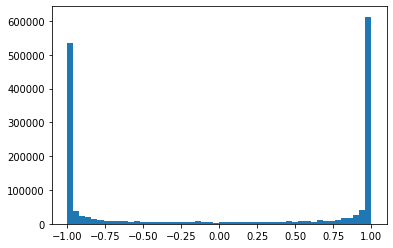

: 

In [34]:
plt.hist(h.view(-1).tolist(),50)

In [11]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4169, grad_fn=<NllLossBackward0>)

In [13]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4126, grad_fn=<NllLossBackward0>)

In [14]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4148, grad_fn=<NllLossBackward0>)

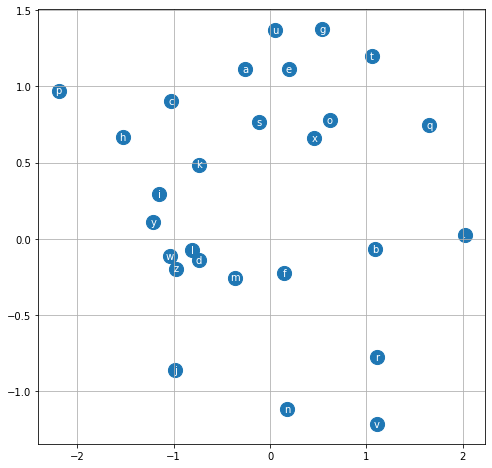

In [15]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

chreah.
qhoril.
khi.
mrix.
thty.
skanden.
jazhutef.
merync.
kaqhi.
nelonia.
chriiv.
ksle.
gph.
lmondin.
qhinn.
shoilea.
jadii.
wattrogiearyxi.
jice.
phrra.
